In [1]:
import numpy as np
import pandas as pd

from nixtla.data.datasets.tourism import Tourism, TourismInfo
from nixtla.experiments.utils import hyperopt_tunning, evaluate_model
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt

In [2]:
group = TourismInfo.groups[2]
print("TourismInfo.groups[0]", group)
Y_test_df, X_test_df, S_df = Tourism.load(directory='../data', group=group)

Y_df = Y_test_df.groupby('unique_id', as_index=False).apply(lambda x: x.iloc[:-24]).reset_index(drop=True)
X_df = None
len_test=24

TourismInfo.groups[0] Monthly


In [3]:
# # NBEATS
# space= {# Architecture parameters
#         'model':'nbeats',
#         'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
#         'output_size': hp.choice('output_size', [24]),
#         'shared_weights': hp.choice('shared_weights', [False]),
#         'activation': hp.choice('activation', ['relu']),
#         'initialization':  hp.choice('initialization', ['lecun_normal']),
#         'stack_types': hp.choice('stack_types', [30*['identity'] ]),
#         'n_blocks': hp.choice('n_blocks', [ 30*[1] ]),
#         'n_layers': hp.choice('n_layers', [ 30*[2] ]),
#         'n_hidden': hp.choice('n_hidden', [512]),
#         'n_harmonics': hp.choice('n_harmonics', [1]),
#         'n_polynomials': hp.choice('n_polynomials', [2]),
#         'exogenous_n_channels': hp.choice('exogenous_n_channels', [0]),
#         'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
#         # Regularization and optimization parameters
#         'batch_normalization': hp.choice('batch_normalization', [False]),
#         'dropout_prob_theta': hp.choice('dropout_prob_theta', [0]),
#         'dropout_prob_exogenous': hp.choice('dropout_prob_exogenous', [0]),
#         'learning_rate': hp.choice('learning_rate', [0.001]),
#         'lr_decay': hp.choice('lr_decay', [0.3]),
#         'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
#         'weight_decay': hp.choice('weight_decay', [0]),
#         'n_iterations': hp.choice('n_iterations', [100]),
#         'early_stopping': hp.choice('early_stopping', [10]),
#         'eval_freq': hp.choice('eval_freq', [5]),
#         'loss': hp.choice('loss', ['MAPE']),
#         'loss_hypar': hp.choice('loss_hypar', [0.5]),                
#         'val_loss': hp.choice('val_loss', ['MAPE']),
#         'l1_theta': hp.choice('l1_theta', [0]),
#         # Data parameters
#         'normalizer_y': hp.choice('normalizer_y', [None]),
#         'normalizer_x': hp.choice('normalizer_x', [None]),
#         'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
#         'complete_inputs': hp.choice('complete_inputs', [False]),
#         'complete_sample': hp.choice('complete_sample', [True]),          
#         'frequency': hp.choice('frequency', ['H']),
#         'seasonality': hp.choice('seasonality', [12]),      
#         'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
#         'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
#         'batch_size': hp.choice('batch_size', [1_024]),
#         'n_series_per_batch': hp.choice('n_series_per_batch', [256]),
#         'random_seed': hp.quniform('random_seed', 10, 20, 1)}

In [4]:
##ESRNN
Y_test_df['y'] = Y_test_df['y'] + 1
Y_df['y'] = Y_df['y'] + 1

space = {'model': hp.choice('model', ['esrnn']),
         # ARCHITECTURE
         'es_component': hp.choice('es_component', ['multiplicative']),
         'cell_type': hp.choice('cell_type', ['LSTM']),
         'state_hsize': hp.quniform('state_hsize', 5, 100, 5),
         'dilations': hp.choice('dilations', [ [[1, 12]], [[1, 4, 8, 12]], [[1, 4], [8, 12]] ]),
         'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
         'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
         # OPTIMIZATION
         'loss': hp.choice('loss', ['SMYL']),
         'max_epochs': hp.choice('max_epochs', [20]),
         'eval_freq': hp.choice('eval_freq', [1]),
         'batch_size': hp.choice('batch_size', [64]),
         'n_series_per_batch': hp.choice('n_series_per_batch', [64]),
         'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
         'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
         'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.3)),
         'lr_scheduler_step_size': hp.choice('lr_scheduler_step_size', [30, 50, 100]),
         'lr_decay': hp.quniform('lr_decay', 0.5, 1.0, 0.1),
         'per_series_lr_multip': hp.choice('per_series_lr_multip', [0.5, 1.0, 1.5, 2.0, 3.0]),
         'gradient_eps': hp.choice('gradient_eps', [1e-8]),
         'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
         'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.01)),
         'level_variability_penalty': hp.quniform('level_variability_penalty', 0, 200, 5),
         'testing_percentile': hp.choice('testing_percentile', [50]),
         'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
         # DATA
         'input_size_multiplier': hp.choice('input_size_multiplier', [0.5]),
         'output_size': hp.choice('output_size', [24]),
         'window_sampling_limit': hp.choice('window_sampling_limit', [24*180]),
         'normalizer_y': hp.choice('normalizer_y', [None]),
         'normalizer_x': hp.choice('normalizer_x', [None]),
         'complete_inputs': hp.choice('complete_inputs', [True]),
         'complete_sample': hp.choice('complete_sample', [True]),
         'seasonality': hp.choice('seasonality', [ [12] ]),
         'random_seed': hp.quniform('random_seed', 1, 1000, 1)}

In [5]:
# Performs hyperopt tunning, outputs results in trials object. timestamps_in_outsample is len of validation set
trials = hyperopt_tunning(space=space, hyperopt_iters=1, loss_function=mape, Y_df=Y_df, X_df=X_df, S_df=S_df,
                          expected_fcds=1, timestamps_in_outsample=24, shuffle_outsample=False)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.010152 seconds
INFO:hyperopt.tpe:TPE using 0 trials
Infered frequency: M
=============== Training ESRNN  ===============

Epoch: 0, Time: 1.442, Insample loss: 15.30294
Epoch: 1, Time: 2.957, Insample loss: 13.66499
Epoch: 2, Time: 4.513, Insample loss: 11.88905
Epoch: 3, Time: 5.993, Insample loss: 11.07602
Epoch: 4, Time: 7.392, Insample loss: 9.89994
Epoch: 5, Time: 8.803, Insample loss: 9.17706
Epoch: 6, Time: 10.289, Insample loss: 8.60368
Epoch: 7, Time: 11.856, Insample loss: 8.11219
Epoch: 8, Time: 13.349, Insample loss: 7.56622
Epoch: 9, Time: 14.789, Insample loss: 7.08084
Epoch: 10, Time: 16.205, Insample loss: 6.60551
Epoch: 11, Time: 17.552, Insample loss: 5.94092
Epoch: 12, Time: 19.025, Insample loss: 5.92158
Epoch: 13, Time: 20.439, Insample loss: 5.50866
Epoch: 14, Time: 21.795, Insample loss: 5.00904
Epoch: 15, Time: 23.226, Insample loss: 4.84410
Epoch: 16, Time: 24.

In [6]:
best_configuration = np.argmin(trials.losses())
best_mc = trials.trials[best_configuration]['result']['mc']

In [7]:
result = evaluate_model(loss_function=mape, mc=best_mc, Y_df=Y_test_df, X_df=X_test_df, S_df=S_df, timestamps_in_outsample=len_test,
                        expected_fcds=1, shuffle_outsample=False)

Infered frequency: M
=============== Training ESRNN  ===============

Epoch: 0, Time: 1.849, Insample loss: 14.62872
Epoch: 1, Time: 3.698, Insample loss: 13.26863
Epoch: 2, Time: 5.538, Insample loss: 11.57783
Epoch: 3, Time: 7.461, Insample loss: 10.75345
Epoch: 4, Time: 9.296, Insample loss: 9.67417
Epoch: 5, Time: 11.139, Insample loss: 8.92047
Epoch: 6, Time: 13.143, Insample loss: 8.39295
Epoch: 7, Time: 15.107, Insample loss: 7.93141
Epoch: 8, Time: 16.974, Insample loss: 7.39697
Epoch: 9, Time: 18.902, Insample loss: 6.94245
Epoch: 10, Time: 20.845, Insample loss: 6.44195
Epoch: 11, Time: 22.860, Insample loss: 5.89072
Epoch: 12, Time: 24.733, Insample loss: 5.71032
Epoch: 13, Time: 26.575, Insample loss: 5.34194
Epoch: 14, Time: 28.660, Insample loss: 4.88588
Epoch: 15, Time: 30.609, Insample loss: 4.73262
Epoch: 16, Time: 32.490, Insample loss: 4.40807
Epoch: 17, Time: 34.352, Insample loss: 4.12709
Epoch: 18, Time: 36.253, Insample loss: 3.90329
Epoch: 19, Time: 38.273, Insa

20.099958777427673

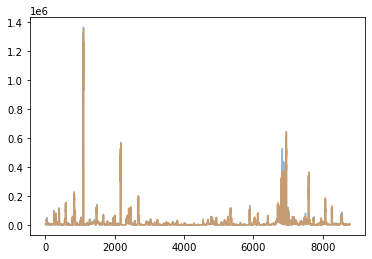

In [9]:
plt.plot(result['y_true'].flatten(), alpha=0.5)
plt.plot(result['y_hat'].flatten(), alpha=0.5)
mape(result['y_true'].flatten(), result['y_hat'].flatten())